In [536]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
%matplotlib widget

In [2]:
x_train = pd.read_csv('./x_train.csv', index_col='ID').fillna(0)
y_train = pd.read_csv('./y_train.csv', index_col='ID').fillna(0)
train = pd.concat([x_train, y_train], axis=1).fillna(0)

In [3]:
ret_cols = [col for col in x_train.columns if 'RET' in col]
vol_cols = [col for col in x_train.columns if 'VOLUME' in col]

In [523]:
sub_ind = 17
df = x_train
df = df[df['DATE']==0]

df = df[df['SECTOR']==2]
df = df[df['INDUSTRY_GROUP']==2]
df = df[df['INDUSTRY']==6]
#df = df[df['SUB_INDUSTRY']==sub_ind]

df_test = train
df_test = df_test[df_test['DATE']==0]

df_test = df_test[df_test['SECTOR']==2]
df_test = df_test[df_test['INDUSTRY_GROUP']==2]
df_test = df_test[df_test['INDUSTRY']==6]
#df_test = df_test[df_test['SUB_INDUSTRY']==sub_ind]

In [524]:
df_rets = df[ret_cols].T.to_numpy()
df_vols = df[vol_cols].T.to_numpy()
df_pca = np.c_[df_rets,df_vols]

In [525]:
R = df_pca - df_pca.mean(axis=0)
n_stock = df_pca.shape[1]//2

R_std = R / R.std(axis=0, ddof=1)


pca = PCA()
pca.fit(R_std)

# Principal components time series (scores)
# shape: (T, N) where each column is a principal component time series
PC_scores = pca.transform(R_std)

# Loadings (eigenvectors), shape: (N, N)
loadings = pca.components_.T

In [526]:
explained_variance = pca.explained_variance_ratio_
# For example, keep the first K components that explain > 80% of variance
K = np.argmax(np.cumsum(explained_variance) > 0.9) + 1

PC_scores = PC_scores[:, :K]  # Keep only the first K principal components
loadings = loadings[:, :K]

[0.17587087 0.31530481 0.40766432 0.49462232 0.56812886 0.63106221
 0.6848271  0.73651432 0.78113988 0.82557575 0.86368947 0.89009067
 0.91365297 0.93555372 0.95353474 0.96968883 0.98210792 0.99221815
 1.         1.        ]


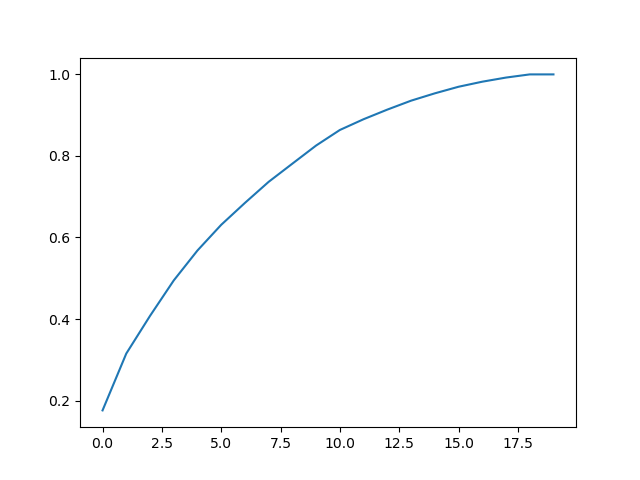

In [527]:
fig, ax = plt.subplots()
#ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
ax.plot(np.cumsum(explained_variance))
print(np.cumsum(explained_variance))

In [528]:
print(PC_scores.shape)
print(R.shape)

(20, 13)
(20, 52)


In [529]:
PC_forecasts = []
steps_ahead = 1  # How many steps you want to forecast

for i in range(K):
    model = ARIMA(PC_scores[:, i], order=(1,0,1))  # simple AR(1) for demonstration
    res = model.fit()
    forecast = res.forecast(steps=steps_ahead)
    PC_forecasts.append(forecast)

In [530]:
#prediction = (PC_forecasts*loadings.T*R.std(axis=0, ddof=1)+df_pca.mean(axis=0))[-1,:n_stock]
prediction=list(np.sign(list((PC_forecasts*loadings.T*R.std(axis=0, ddof=1)+df_pca.mean(axis=0))[-1,:n_stock])) == 1.)

In [531]:
prediction

[True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True]

In [532]:
df_test['RET'].to_list()

[True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False]

In [533]:
acc = 0
for jj in range(n_stock):
    pred = False
    if prediction[jj] > 0:
        pred = True
    else:
        pred = False
    if df_test['RET'].iloc[jj] == pred:
        acc +=1
acc/=n_stock
print(acc*100)

57.692307692307686


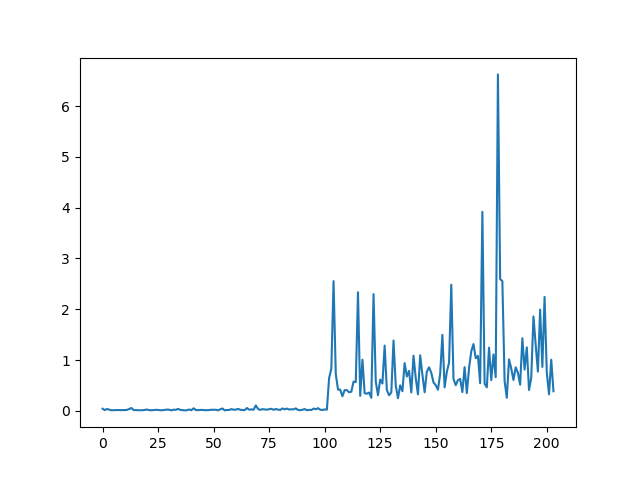

In [367]:
fig, ax = plt.subplots()
ax.plot(R.std(axis=0, ddof=1))

In [162]:
np.max(R.std(axis=0, ddof=1))

19.792193783567477

In [170]:
np.argwhere(np.isnan(R_std))[0]

array([   0, 2378])

In [546]:
#prediction = []
#stock_ind = []

df = x_train
df = x_train#[x_train['DATE']==0]



acc = 0
total_size = df.shape[0]
for idx, date in zip(tqdm(range(df["DATE"].unique().size)),df["DATE"].unique()):
    df_date = df[df["DATE"]==date]
    #print("Date: ", date)
    for  sector in df_date["SECTOR"].unique():
        
        df_sector = df_date[df_date["SECTOR"]==sector]
        for ind_group in df_sector["INDUSTRY_GROUP"].unique():
            df_ind_group = df_sector[df_sector["INDUSTRY_GROUP"]==ind_group]
            for industry in df_ind_group["INDUSTRY"].unique():
                df_ind = df_ind_group[df_ind_group["INDUSTRY"]==industry]
                df_rets = df_ind[ret_cols].T.to_numpy()
                df_vols = df_ind[vol_cols].T.to_numpy()
                df_pca = np.c_[df_rets,df_vols]
                #df_pca = df_rets
    
                R = df_pca - df_pca.mean(axis=0)
                n_stock = df_pca.shape[1]//2
    
                std_vals = R.std(axis=0, ddof=1)
                #R = R[:, std_vals != 0]
                
                epsilon = 1e-8
                R_std = R / (std_vals + epsilon)
                
                
                pca = PCA()
                pca.fit(R_std)
                
                # Principal components time series (scores)
                # shape: (T, N) where each column is a principal component time series
                PC_scores = pca.transform(R_std)
                
                # Loadings (eigenvectors), shape: (N, N)
                loadings = pca.components_.T
    
                explained_variance = pca.explained_variance_ratio_
                # For example, keep the first K components that explain > 80% of variance
                K = np.argmax(np.cumsum(explained_variance) > 0.6) + 1
                
                PC_scores = PC_scores[:, :K]  # Keep only the first K principal components
                loadings = loadings[:, :K]
                
                PC_forecasts = []
                steps_ahead = 1  # How many steps you want to forecast
                
                for i in range(K):
                    model = ARIMA(PC_scores[:, i], order=(1,0,1))  # simple AR(1) for demonstration
                    #model = SARIMAX(PC_scores[:, i], order=(1, 0, 0), enforce_stationarity=True, enforce_invertibility=True)
                    res = model.fit()
                    forecast = res.forecast(steps=steps_ahead)
                    PC_forecasts.append(forecast)
    
                prediction = list(np.sign(list((PC_forecasts*loadings.T*R.std(axis=0, ddof=1)+df_pca.mean(axis=0))[-1,:n_stock])) ==1)
                #prediction = list(np.sign(list((PC_forecasts*loadings.T*R.std(axis=0, ddof=1)+df_pca.mean(axis=0))[-1])) ==1)
                stock_ind = df_ind.index#.to_list()
                train_forecast = train.loc[stock_ind]['RET'].values

                for ii in range(len(prediction)):
                    if prediction[ii] == train_forecast[ii]:
                        acc+=1.0
acc/=total_size
print(acc*100)

100%|█████████████████████████████████████████| 156/156 [17:47<00:00,  6.84s/it]

49.86872752899581
